#   <CENTER>PORTFOLIO 2</CENTER>
## Task P2.1
### Realize an implementation of the <b>Kalman Filter</b> in a programming language of your choice for a simulation of the ball-throwing example from the lecture slides. The task of your Kalman Filter is to estimate the position and velocity vector of the ball only from the observed erroneous positions over time.

In [240]:
#Importing libraries
import numpy as np
from matplotlib import pyplot as plt

### Constants

In [241]:
G = 9.81 # Acceleration due to gravity
DT = 0.1  # seconds

#### Ball Trajectory Simulation for Kalman Filter

In [242]:
# Function to simulate ball trajectory
def ball_trajectory_simulation(launch_position, launch_speed, launch_angle, DT, duration, g=G): 

    # Convert launch angle to radians
    launch_angle_rad = np.deg2rad(launch_angle)

    # Calculate initial velocity components
    initial_velocity_x = launch_speed * np.cos(launch_angle_rad)
    initial_velocity_y = launch_speed * np.sin(launch_angle_rad)

    # Calculate time array
    t = np.arange(0, duration, DT)

    # Calculate ball position at each time step
    x = launch_position[0] + initial_velocity_x * t
    y = launch_position[1] + initial_velocity_y * t - 0.5 * g * t**2

    # Calculate velocity components
    vx = initial_velocity_x * np.ones_like(t)
    vy = initial_velocity_y - g * t

    return x, y, vx, vy

#### Ball Observations Simulation for Kalman Filter

In [243]:
# Function to simulate observations with noise and dropout
def ball_observations_simulation(true_x, true_y, obs_noise_covar, obs_dropout_prob):
    n = len(true_x)  # Number of time steps

    # Generate random noise for observations
    observation_noise = np.random.multivariate_normal([0, 0], obs_noise_covar, n)

    # Simulate observations with dropout
    observations = []
    for i in range(n):
        if np.random.rand() > obs_dropout_prob:
            observations.append([true_x[i] + observation_noise[i, 0], true_y[i] + observation_noise[i, 1]])
        else:
            observations.append(None)

    return observations


#### Kalman Filter Implementation

In [244]:
class KalmanFilter:
    def __init__(self, F, B, H, Q, R, x0, P0):
        self.F = F
        self.B = B
        self.H = H
        self.Q = Q
        self.R = R
        self.x = x0
        self.P = P0

    def predict(self):
        # Predicts the next state and error covariance.
        self.x = self.F @ self.x + self.B
        self.P = self.F @ self.P @ self.F.T + self.Q

    def update(self, z):
        # Updates the state and error covariance based on the observation.
        y = z - self.H @ self.x
        S = self.H @ self.P @ self.H.T + self.R
        K = self.P @ self.H.T @ np.linalg.inv(S)
        self.x = self.x + K @ y
        self.P = (np.eye(self.F.shape[0]) - K @ self.H) @ self.P

    def run_filter(self, observations):
        # Runs the Kalman Filter over a sequence of observations.
        n = len(observations)  #Number of time step
        m = self.x.shape[0]    #Dimension of state vector

        x_estimates = np.zeros((n, m))
        P_estimates = np.zeros((n, m, m))

        x_estimates[0] = self.x
        P_estimates[0] = self.P

        for k in range(1, n):
            self.predict()
            if observations[k] is not None:
                self.update(observations[k])
            x_estimates[k] = self.x
            P_estimates[k] = self.P

        return x_estimates, P_estimates

#### <b>Ball Simulation Parameters 1</b>

In [245]:
# Setting up simulation parameters
launch_position = [10, 10]
launch_speed = 50  # m/s
launch_angle = 45 # degrees
duration = 10  # seconds
obs_noise_covar = np.diag([0.1, 0.1])**2
obs_dropout_prob = 0.1

# Ball Trajectory Simulation and Observations
true_x, true_y, true_vx, true_vy = ball_trajectory_simulation(launch_position, launch_speed, launch_angle, DT, duration)
observations = ball_observations_simulation(true_x, true_y, obs_noise_covar, obs_dropout_prob)


In [246]:
# Ball Trajectory Simulation and Observations
true_x, true_y, true_vx, true_vy = ball_trajectory_simulation(launch_position, launch_speed, launch_angle, DT, duration)
observations = ball_observations_simulation(true_x, true_y, obs_noise_covar, obs_dropout_prob)
len(observations)

100

#### Kalman Filter Parameters

In [247]:
# Adjusting Kalman Filter Parameters
F = np.array([[1, 0, DT, 0],  # State transition matrix
              [0, 1, 0, DT],
              [0, 0, 1, 0],
              [0, 0, 0, 1]])
B = np.array([0, 0, 0, -9.81*DT])  # Control input matrix for gravity
H = np.array([[1, 0, 0, 0],  # Observation matrix
              [0, 1, 0, 0]])
Q = np.diag([0.1, 0.1, 0.1, 0.1])**2  # Process noise covariance matrix
R = np.diag([0.1, 0.1])**2  # Observation noise covariance matrix
x0 = np.array([launch_position[0], launch_position[1], 20*np.cos(np.deg2rad(launch_angle)), 20*np.sin(np.deg2rad(launch_angle))])  # Initial state estimate
P0 = np.diag([1, 1, 1, 1])  # Initial error covariance matrix

In [248]:
# Apply Kalman Filter
kf = KalmanFilter(F, B, H, Q, R, x0, P0)
x_estimates, P_estimates = kf.run_filter(observations)

### Plotting the first result of Observations, True trajectory, and Estimated trajectory

(0.0, 83.45211217270663)

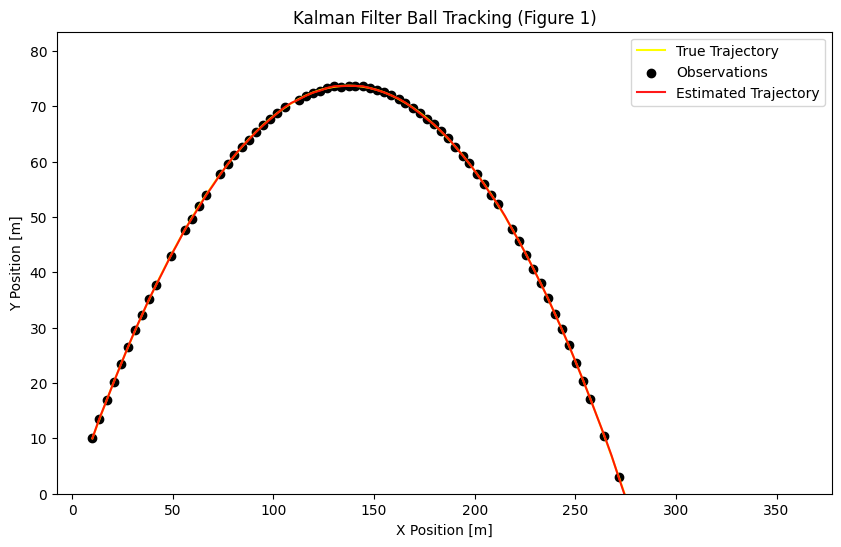

In [249]:
# Plot results
plt.figure(figsize=(10, 6))
plt.plot(true_x, true_y, label='True Trajectory', color='yellow')
plt.scatter([o[0] for o in observations if o is not None], [o[1] for o in observations if o is not None], label='Observations', color='black')
plt.plot(x_estimates[:, 0], x_estimates[:, 1], label='Estimated Trajectory', color='red', alpha=0.9)
plt.legend()
plt.title('Kalman Filter Ball Tracking (Figure 1)')
plt.xlabel('X Position [m]')
plt.ylabel('Y Position [m]')
plt.ylim(bottom=0)

### Function to calculate error

In [250]:
# Function to calculate RMSE
def calculate_rmse(estimated_trajectory, true_trajectory):
    error = estimated_trajectory - true_trajectory
    rmse = np.sqrt(np.mean(error**2))
    return rmse

# Calculate RMSE
rmse = calculate_rmse(x_estimates[:, :2], np.column_stack((true_x, true_y)))
print(f'Root Mean Square Error of Figure 1 is: {rmse}')

Root Mean Square Error of Figure 1 is: 0.12587789313377792


### Plotting the first result of True velocity Vs Estimated velocity

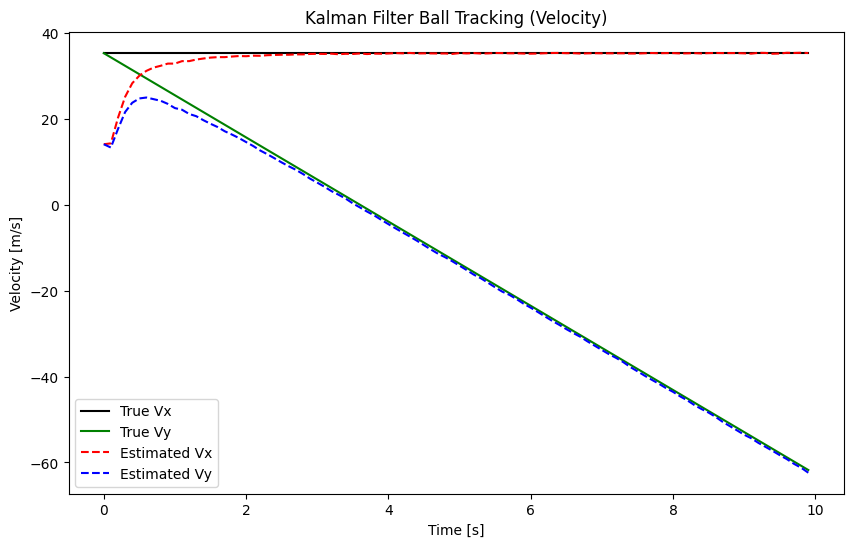

In [251]:
#Plot velocity results
plt.figure(figsize=(10, 6))
plt.plot(np.arange(0, duration, DT), true_vx, label='True Vx', color='black')
plt.plot(np.arange(0, duration, DT), true_vy, label='True Vy', color='green')
plt.plot(np.arange(0, duration, DT), x_estimates[:, 2], label='Estimated Vx', color='red', linestyle='--')
plt.plot(np.arange(0, duration, DT), x_estimates[:, 3], label='Estimated Vy', color='blue', linestyle='--')
plt.legend()
plt.title('Kalman Filter Ball Tracking (Velocity)')
plt.xlabel('Time [s]')
plt.ylabel('Velocity [m/s]')
plt.show()


 # <center>THANK YOU</center>